In [1]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

In [2]:
repertoireCourant = os.getcwd()

In [3]:
data = pd.read_csv(os.path.join(repertoireCourant, 'QueryResults_2017.csv'))

<H3>Nettoyage de la colonne Tags</H3>

In [4]:
data.head(2)

,CreationDate,ViewCount,Title,Body,Tags
0,2017-01-12 01:57:22,3143,Spring boot project failing with NoSuchMethodE...,"<p>I have a simple Spring Boot project, I have...",<tomcat><spring-boot>
1,2017-01-12 02:42:09,14227,How to display local image in markdown,"<p>I try the following in markdown, but seems ...",<markdown>


In [5]:
"Nombre de question en 2017: {}".format(len(data))

'Nombre de question en 2017: 18997'

In [6]:
def nettoyageTags(chaineCaractere):
    nlleChaineCaractere = chaineCaractere.replace("><", ",")
    nlleChaineCaractere = nlleChaineCaractere.replace("<", "")
    nlleChaineCaractere = nlleChaineCaractere.replace(">", "")
    return nlleChaineCaractere

In [7]:
data["Tags"] = data["Tags"].apply(nettoyageTags)

<H3>Analyse des tags</H3>

In [8]:
#analyse de la fréquence des tags
frequence_tags = {}
for i, row in data.iterrows():
    for tag in row["Tags"].split(","):
        reponse = frequence_tags.get(tag, -1)
        if reponse == -1:
            frequence_tags[tag] = 1
        else:
            frequence_tags[tag] += 1

In [9]:
"Nombre de tags différents: {}".format(len(frequence_tags))

'Nombre de tags différents: 6049'

In [10]:
tags = []
freq = []
for k, v in frequence_tags.items():
    tags.append(k)
    freq.append(v)
df_tags_freq  = pd.DataFrame({"Tag": tags, "freq": freq})

In [11]:
df_tags_freq = df_tags_freq.sort_values('freq', ascending = False)
df_tags_freq['%'] = df_tags_freq['freq'] / df_tags_freq['freq'].sum() * 100
df_tags_freq['%cumule'] = df_tags_freq['%'].cumsum()

Text(0.5, 1.0, 'Listes des 50 tags les plus cités en 2017')

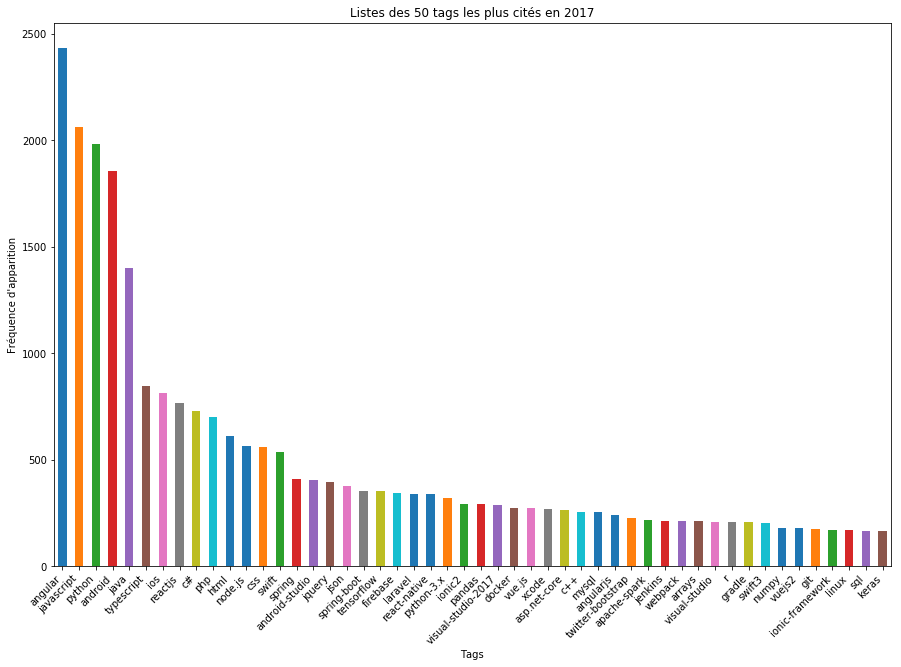

In [12]:
plt.figure(figsize = (15, 10))
df_tags_freq.iloc[:50]['freq'].plot(kind = "bar")
plt.xticks(range(len(df_tags_freq.iloc[:50])), list(df_tags_freq.iloc[:50]['Tag']), rotation = 45, horizontalalignment='right')
plt.xlabel("Tags")
plt.ylabel("Fréquence d'apparition")
plt.title("Listes des 50 tags les plus cités en 2017")

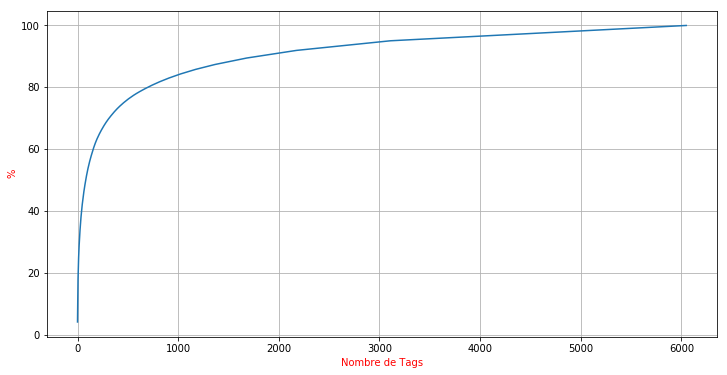

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(df_tags_freq)), df_tags_freq['%cumule'])
plt.xlabel("Nombre de Tags", color = "red")
plt.ylabel("%", color = "red")
plt.grid()

In [14]:
quantile = df_tags_freq['freq'].quantile([i / 100 for i in range(10, 100, 1)])
df_quantile = pd.DataFrame({"freq": list(quantile)}, index = quantile.index)
df_quantile["% apparition"] = df_quantile['freq'] / len(data) * 100

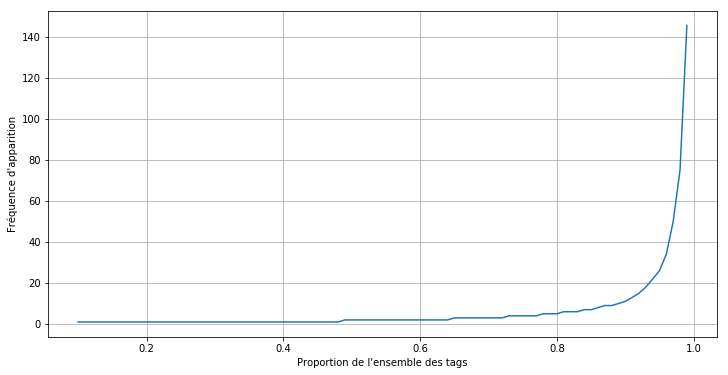

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(df_quantile.index, df_quantile["freq"])
plt.xlabel("Proportion de l'ensemble des tags")
plt.ylabel("Fréquence d'apparition")
plt.grid()

In [16]:
for i, row in df_quantile.iterrows():
    print(i,"\t", row['freq'], "\t", row['% apparition'])

0.1 	 1.0 	 0.005263989050902774
0.11 	 1.0 	 0.005263989050902774
0.12 	 1.0 	 0.005263989050902774
0.13 	 1.0 	 0.005263989050902774
0.14 	 1.0 	 0.005263989050902774
0.15 	 1.0 	 0.005263989050902774
0.16 	 1.0 	 0.005263989050902774
0.17 	 1.0 	 0.005263989050902774
0.18 	 1.0 	 0.005263989050902774
0.19 	 1.0 	 0.005263989050902774
0.2 	 1.0 	 0.005263989050902774
0.21 	 1.0 	 0.005263989050902774
0.22 	 1.0 	 0.005263989050902774
0.23 	 1.0 	 0.005263989050902774
0.24 	 1.0 	 0.005263989050902774
0.25 	 1.0 	 0.005263989050902774
0.26 	 1.0 	 0.005263989050902774
0.27 	 1.0 	 0.005263989050902774
0.28 	 1.0 	 0.005263989050902774
0.29 	 1.0 	 0.005263989050902774
0.3 	 1.0 	 0.005263989050902774
0.31 	 1.0 	 0.005263989050902774
0.32 	 1.0 	 0.005263989050902774
0.33 	 1.0 	 0.005263989050902774
0.34 	 1.0 	 0.005263989050902774
0.35 	 1.0 	 0.005263989050902774
0.36 	 1.0 	 0.005263989050902774
0.37 	 1.0 	 0.005263989050902774
0.38 	 1.0 	 0.005263989050902774
0.39 	 1.0 	 0.00

On constate qu'une très forte proportion des tags apparaissent très peu au regard du nombre de question:
90 % des tags (5444) apparaisent moins de 11 fois sur une base de donnée comportant 18 997 questions
--> Supression des tags figurant moins de 11 fois: si la question n'a plus de tags après suppression alors la question est supprimée

In [17]:
def tagsCleaned(tags, seuil):
    tags2 = []
    for tag in tags.split(","):
        if frequence_tags[tag] >= seuil:
            tags2.append(tag)
    if len(tags2) > 1:
        return ",".join(tags2)
    else:
        return np.nan

In [18]:
data['Tags cleaned'] = data['Tags'].apply(lambda x: tagsCleaned(x, 11))

In [19]:
#Nombre de question restante
"{} % de la base de donnée est conservée après nettoyage des Tags".format(round(len(data[data["Tags cleaned"].notnull()]) / len(data) * 100), 2)

'79 % de la base de donnée est conservée après nettoyage des Tags'

In [20]:
data = data[data["Tags cleaned"].notnull()]

<H3>Analyse du corps des questions</H3>

In [21]:
#Proportion du code versus la question
listeNbreCaracteresBody = []
listeNbreCaracteresCode = []
for i, row in data.iterrows():
    soup = BeautifulSoup(row['Body'])
    codes = soup.find_all("code")
    nbrCarBody = len(row['Body'])
    nbrCarCode = 0
    for code in codes:
        nbrCarCode += len(code.text)
    listeNbreCaracteresBody.append(nbrCarBody)
    listeNbreCaracteresCode.append(nbrCarCode)

In [22]:
statNbreCaract = pd.DataFrame(data = {"nbre caracteres Body": listeNbreCaracteresBody, "nbre caracteres code": listeNbreCaracteresCode}, index = data.index)

In [23]:
statNbreCaract['Proportion'] = round((statNbreCaract['nbre caracteres code'] / statNbreCaract['nbre caracteres Body']) * 100, 2)

In [24]:
statNbreCaract.describe()

,nbre caracteres Body,nbre caracteres code,Proportion
count,14984.000000,14984.000000,14984.000000
mean,1710.325414,1002.015550,39.280817
std,2346.613678,2122.711846,28.511986
min,53.000000,0.000000,0.000000
25%,593.000000,78.000000,12.697500
50%,1039.000000,362.000000,39.630000
75%,1912.000000,1037.000000,62.760000
max,30033.000000,28824.000000,99.760000


In [25]:
def nettoyage_texte(texte):
    for motif in [r"\n", r'<code>.*?<\/code>', r"<.*?>", r"\r", r"(\w+\/)+[\w+\.]+", r'https?://[\S]+', r"(\w+\.)+\w+", r"\$\w+", r'\b(\w)\1+\b', r"  +", r"\b[0-9]+\b"]:
        while re.search(motif, texte):
            texte = re.sub(motif, " ", texte)
    return texte

In [26]:
data['Title_Body'] = data[["Title", "Body"]].apply(lambda x: nettoyage_texte(x['Title'] + " " + x['Body']), axis = 1)

In [27]:
data['nbre_mot_title_body'] = data['Title_Body'].apply(lambda x: len(x.split()))

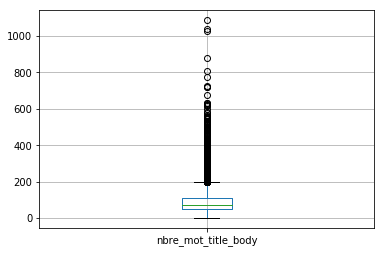

In [28]:
data[['nbre_mot_title_body']].boxplot()

In [29]:
data['nbre_mot_title_body'].quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.001     13.00
0.010     21.00
0.050     31.00
0.250     52.00
0.500     74.00
0.750    111.00
0.950    204.00
0.990    333.17
Name: nbre_mot_title_body, dtype: float64

(-50, 750)

C:\Users\Lies\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


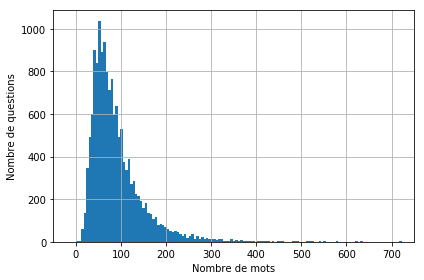

In [30]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(data['nbre_mot_title_body'], bins= 200)
plt.grid()
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de questions")
plt.xlim(-50, 750)

<h2>TOKENIZATION</h2>

In [31]:
# Il s'agit de "casser" le texte en conservant les mots et d'obtenir ainsi un "sac de mots" (bag of words)

In [32]:
from nltk.tokenize import RegexpTokenizer
treebank_wt = nltk.TreebankWordTokenizer()

In [33]:
%%time
texte_token = []
for question in list(data['Title_Body']):
    texte_token.append(treebank_wt.tokenize(question))

Wall time: 8.29 s


<H3>SUPPRESSION DE MOTS CONSTITUE UNIQUEMENT DE CHIFFRE ET TRANSFORMATION EN MINUSCULE DES MOTS</H3>

In [34]:
%%time
for i, question in enumerate(texte_token):
    q = []
    for mot in question:
        if re.match(r"\d", mot) is None:
            q.append(mot.lower())
    texte_token[i] = q

Wall time: 3.24 s


<h3>SUPPRESSION DES PONCTUATIONS, DES MOTS AVEC _ ET DES MOTS VIDES</h3>

In [35]:
stopwords_english = set(ENGLISH_STOP_WORDS)

In [36]:
#On nettoie chaque document "tokenisé" des ponctuations et des mots vides

In [37]:
%%time
ponctuations = string.punctuation
for i in range(len(texte_token)):
    x = [m for m in texte_token[i] if not (m in ponctuations)]
    expression = re.compile(r"[a-zA-Z0-9]+")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = expression.search(x[j]).group(0)
        else:
            x[j] = ''
    expression = re.compile(r"([a-zA-Z]+_)+[a-zA-Z]*")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = ''
    x = [m for m in x if not (m in stopwords_english)]
    texte_token[i] = [m for m in x if not(len(m) <= 1)]

Wall time: 3.21 s


<h3>LEMMATISATION</H3>

In [38]:
#Normalisation des mots en ne conservant que la racine des mots

In [39]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [40]:
%%time
for i in range(len(texte_token)):
    texte_token[i] = [wnl.lemmatize(m) for m in texte_token[i]]

Wall time: 5.36 s


<h3>Reconstitution des question à partir du "sac de mots</h3>

In [41]:
texte_token2 = []
for i in range(len(texte_token)):
    texte_token2.append(" ".join(texte_token[i]))

data2 = pd.DataFrame({'Body': texte_token2}, index = data.index)

In [42]:
data['Title_Body_cleaned'] = data2['Body']

In [43]:
data = data[['CreationDate', 'ViewCount', 'Title', 'Body','Title_Body', 'Title_Body_cleaned', 'Tags', 'Tags cleaned', 'nbre_mot_title_body']]

<H2>CREATION JEU ENTRAINEMENT ET JEU TEST</H2>

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
Quest_train, Quest_test, Tags_train, Tags_test = train_test_split(data[['Title_Body_cleaned']], data[['Tags cleaned']])

In [46]:
dictionnaire_tags_train = []
for i, row in Tags_train.iterrows():
    for m in row["Tags cleaned"].split(","):
        dictionnaire_tags_train.append(m)
dictionnaire_tags_train = list(set(dictionnaire_tags_train))
dictionnaire_tags_train.sort()

In [47]:
len(dictionnaire_tags_train)

647

<h3>Création d'une matrice avec en ligne le corpus (question) d'un jeu d'entrainement et en colonne les tags<h3>

In [48]:
%%time
#Instructions servant à mettre dans l'ordre alphabétique les tags
for i, row in Tags_train.iterrows():
    liste = row["Tags cleaned"].split(",")
    liste.sort()
    Tags_train["Tags cleaned"].loc[i] = ",".join(liste)

Wall time: 9.09 s


In [49]:
%%time
#/!\ il est indispensable de classer en ordre (croissant ou décrossant les tags avant d'utiliser cette méthode)
Tags_train_vect = Tags_train['Tags cleaned'].str.get_dummies(sep = ",")

Wall time: 37.2 s


In [81]:
Tags_train_vect

,.htaccess,.net,.net-core,.net-standard,adb,airflow,ajax,alamofire,algorithm,amazon-dynamodb,...,xcode8,xcode9,xcode9-beta,xml,xmlhttprequest,yahoo-finance,yaml,yarnpkg,yii2,youtube
817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>COUNT VECTORISOR</h2>

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
#vect = CountVectorizer(min_df = 0.02, max_df = 0.98)
vect = CountVectorizer(min_df = 0.003, max_df = 0.997)

In [51]:
vect.fit(Quest_train['Title_Body_cleaned'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.997, max_features=None, min_df=0.003,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [52]:
dictionnaire = vect.get_feature_names()

In [53]:
len(dictionnaire)

1370

In [54]:
Quest_train_vect = vect.transform(Quest_train['Title_Body_cleaned'])

In [55]:
Quest_test_vect = vect.transform(Quest_test['Title_Body_cleaned'])

In [56]:
#Création d'une matrice creuse avec en colonnes le dictionnaire de mots
#en ligne le CORPUS
#
Quest_train_vect

<11238x1370 sparse matrix of type '<class 'numpy.int64'>'
	with 268807 stored elements in Compressed Sparse Row format>

In [57]:
for k in range(Quest_train_vect.shape[0]):
    print("Document " + str(k))
    for i, freq in enumerate(Quest_train_vect.toarray()[k]):
        if freq > 0:
            print("{} : {}".format(dictionnaire[i], freq))
    print()
    if k == 5:
        break

Document 0
anymore : 2
api : 3
containing : 1
custom : 6
defined : 1
description : 3
developer : 1
documentation : 1
doe : 2
facebook : 10
init : 1
just : 1
like : 1
missing : 1
need : 1
new : 1
obviously : 1
page : 1
parameter : 2
picture : 4
procedure : 1
reason : 1
result : 2
say : 1
setup : 1
share : 5
supported : 1
tag : 1
test : 1
text : 1
thing : 1
title : 3
update : 1
use : 1
version : 4
want : 2
way : 1
website : 1
workaround : 1
worked : 1
working : 2

Document 1
action : 1
add : 1
coming : 1
component : 7
context : 1
created : 1
data : 4
doe : 1
doing : 2
executed : 1
following : 1
form : 2
function : 3
grid : 3
look : 1
manually : 1
menu : 1
method : 1
navigate : 2
navigation : 2
new : 2
object : 3
page : 3
problem : 1
reason : 1
redirect : 1
refresh : 3
showing : 1
submit : 1
table : 1
target : 2
tell : 1
trying : 2
updating : 1
using : 2

Document 2
able : 2
answer : 1
application : 4
background : 3
basically : 1
black : 2
change : 6
choose : 2
code : 1
color : 7
create :

<H2>LATENT DIRICHLET ALLOCATION</H2>

Cette méthode tente de regrouper les documents contenant des sous-ensemble de mots communs

In [58]:
from sklearn.decomposition import LatentDirichletAllocation as lda

In [59]:
nbre_sujet = 1200

In [60]:
#model = lda(n_components = nbre_sujet, max_iter = 20)
model = lda(n_components = nbre_sujet)

In [61]:
%%time
model.fit(Quest_train_vect)

Wall time: 9min 1s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=1200, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [62]:
#Nous affichons pour chacun des 10 sujets
#les 10 mots les plus représentatifs
for i in range(nbre_sujet):
    df99 = pd.DataFrame({"mot": dictionnaire, "coef": model.components_[i]})
    print(i)
    print(df99.sort_values("coef", ascending= False)[:10])
    print()

0
          mot        coef
1119     site  259.682925
918   problem    4.682088
356       doe    4.025717
525       got    3.149607
713   machine    2.668360
514     given    2.232908
1294     user    1.567369
1307       ve    0.886053
745   mention    0.884108
1291      use    0.384183

1
          mot       coef
1051   safari  67.035147
1346     work   6.983567
356       doe   5.362478
678      like   4.437900
1309  version   3.588405
50     appear   3.000833
968    reason   2.751009
471   firefox   2.584073
1193     sure   2.534770
1279   update   1.933703

2
         mot        coef
17    adding  362.166197
15       add   44.938284
94      away   34.484551
791      new   31.511751
1223   thing   19.569372
406    error   16.660713
358    doing   15.077791
1307      ve   13.157050
1250   tried   12.418264
148       ca   10.520488

3
           mot        coef
1023  response  487.563125
240    console   30.483618
510    getting   29.607061
36     angular   18.943393
750     method   1

            mot        coef
542   happening  120.714494
538     handler   75.458526
1062   scenario   67.566827
792      newbie   45.603711
234   confusing   26.791424
1256     trying   23.044937
198        code   22.595557
1074     second   17.724337
467        fine    6.648663
1255        try    5.310468

41
              mot        coef
710            lt  110.586291
406         error    9.679295
54    application    6.087583
1346         work    5.480142
749       message    2.979862
678          like    2.853170
1255          try    2.666601
95            aws    2.000833
483     following    1.918638
1307           ve    1.846846

42
            mot        coef
1082   selenium  203.710651
1329  webdriver   47.234939
198        code   37.513879
406       error   21.269408
1250      tried   19.650252
1291        use   17.519650
182      chrome   16.417460
1047    running   16.126503
1309    version   10.268525
510     getting    8.266496

43
                mot       coef
795        

          mot        coef
574      icon  262.000833
48        app   40.401205
759   missing   12.865372
1256   trying    7.949743
525       got    3.250039
1250    tried    3.097627
1265   unable    3.047418
1179   submit    2.422694
461      file    2.351373
1221   thanks    1.034266

99
            mot       coef
989       regex  63.397169
316   described  50.998716
1214       term  40.662595
263     correct   7.772882
898    possible   4.903353
650        just   3.176144
1127   solution   1.820626
1231       time   0.874982
954    question   0.841276
356         doe   0.711446

100
           mot        coef
955      quite  123.111484
954   question    9.555790
713    machine    7.942838
1307        ve    5.743156
717       make    5.276734
963       read    4.930730
577       idea    4.192278
467       fine    2.609888
123        bit    2.424872
42      answer    2.046851

101
          mot      coef
46        api  9.612223
998    remote  6.000833
489   forward  4.203109
487      f

              mot       coef
924    production  80.737401
461          file   8.899031
54    application   6.071440
1346         work   5.763484
413       example   5.042566
1097          set   4.607438
148            ca   4.516931
1094       server   4.197475
1047      running   3.439893
786          need   3.370993

152
          mot        coef
735     maven  199.660948
930   project   60.442686
678      like   22.086274
704      look   16.960611
550      help   12.332295
272    create   10.739542
1307       ve    7.663308
650      just    6.973733
1037    right    5.016206
1193     sure    4.729399

153
              mot      coef
898      possible  7.000631
198          code  5.215914
1307           ve  2.976205
104         based  2.000833
1080     selected  2.000833
1003     rendered  2.000833
8         achieve  2.000833
336     different  2.000833
373   dynamically  2.000833
1279       update  1.937944

154
            mot        coef
732    material  199.949639
739          md 

            mot        coef
69     assembly  110.248938
1309    version   23.177323
984   reference   22.092662
789         net   13.428268
406       error   11.381151
492   framework   10.552272
1279     update    8.260565
461        file    6.015328
1292       used    5.673685
1256     trying    4.905394

205
            mot        coef
653         key  567.643166
1296      using   32.463482
1256     trying   19.558329
483   following   14.896468
461        file   13.233185
1356      wrong   12.517065
1291        use   12.230195
273     created   11.732105
198        code    9.970554
356         doe    9.808916

206
            mot       coef
744      memory  12.000897
1302      value   8.000905
619     integer   6.000859
618         int   6.000833
853         pas   5.048297
638        java   5.000833
650        just   4.000916
64        array   4.000845
1343  wondering   3.000833
750      method   3.000833

207
                mot        coef
1269  understanding  117.819866
1217    

             mot      coef
653          key  4.000833
358        doing  4.000833
638         java  3.999781
525          got  3.000833
673       length  3.000833
900         post  3.000833
639   javascript  3.000833
510      getting  3.000833
1326         way  2.991447
1250       tried  2.987844

265
          mot        coef
833    option  501.570417
1098  setting   21.809120
48        app   10.255992
1224    think    9.666658
577      idea    9.247199
188     click    8.497036
1291      use    5.041220
15        add    4.853552
1346     work    4.749245
1292     used    3.796748

266
            mot        coef
426    expected  332.532695
143       built  105.663920
406       error   60.252766
525         got   46.990500
198        code   31.727393
918     problem   13.755716
1255        try   11.426135
273     created   11.022559
483   following   10.792744
1346       work    8.950442

267
          mot       coef
851      part  38.771957
1231     time  11.709636
198      code   6.0

           mot        coef
63    argument  263.279060
406      error   40.197651
759    missing   16.669352
510    getting   15.349677
497   function    8.690974
680       line    8.518017
678       like    8.187930
1193      sure    6.521978
272     create    4.743313
1356     wrong    4.604462

325
          mot      coef
165      cell  6.174234
959     range  5.000833
1079   select  3.000833
695   located  3.000833
635      item  3.000833
684      list  3.000833
198      code  2.594191
1294     user  2.000833
319   desired  2.000833
1103    sheet  2.000833

326
           mot        coef
173    channel  123.928593
272     create   14.129547
1326       way    7.990520
749    message    6.400152
1296     using    5.281270
15         add    3.904950
678       like    3.783042
1084      send    3.318764
497   function    3.275199
148         ca    3.214005

327
          mot        coef
459    figure  395.921038
1256   trying   71.338920
0        able   33.775633
198      code   21.9059


379
          mot        coef
1251  trigger  101.471746
445      fail   70.000833
1307       ve   13.255132
0        able    7.729737
918   problem    6.881794
148        ca    6.246805
791       new    5.489437
577      idea    4.927754
198      code    4.695735
334       did    3.907526

380
          mot        coef
827      open  485.351141
368    driver   96.012779
1255      try   42.576203
656      know   15.058547
786      need   10.353829
678      like    8.834577
717      make    5.719526
1349  working    5.079113
1296    using    4.926022
1231     time    4.393535

381
            mot       coef
974   recognize  37.000833
1023   response  10.686513
356         doe   9.749713
483   following   7.536895
1118     single   7.000833
678        like   6.260361
183       class   4.864093
765       model   4.133239
59     approach   4.000833
1294       user   3.477409

382
                mot        coef
246       container  320.625126
352          docker   64.500077
1291           

           mot       coef
990   register  78.449339
1307        ve   9.080953
638       java   7.841580
576        ide   4.866110
413    example   3.274649
206    command   3.136453
1231      time   3.063559
269     course   3.043816
148         ca   2.414403
170     change   2.322217

436
            mot        coef
1299      valid  148.610217
1021   resolved   72.669591
406       error   46.693411
1256     trying   21.054989
483   following   13.774587
510     getting    9.276732
198        code    7.222857
858        path    5.879082
930     project    5.015931
1265     unable    3.451700

437
          mot        coef
782    navbar  114.627581
704      look    5.840826
413   example    4.794161
1037    right    4.125873
148        ca    3.359323
1346     work    2.421539
634     issue    2.384128
1339   window    2.330548
1250    tried    2.316110
1307       ve    2.129683

438
          mot        coef
260      copy  178.924140
1291      use    9.193230
1296    using    3.454778
1

          mot       coef
523   googled  40.549389
374   earlier  34.147583
1307       ve   9.797818
918   problem   7.635547
791       new   7.329867
1309  version   5.522232
550      help   4.574504
1255      try   4.167925
22    advance   2.536668
272    create   2.414204

493
             mot        coef
242   constraint  134.506473
73    associated   29.246507
1097         set   15.514501
786         need   13.412319
1037       right    9.234400
358        doing    6.520728
198         code    5.455982
406        error    5.394699
1255         try    5.324607
1307          ve    5.275564

494
            mot       coef
350         dll  65.247687
461        file  18.588274
930     project   7.465046
334         did   6.563616
69     assembly   5.592842
1193       sure   3.746821
789         net   3.636058
688        load   2.824632
480      folder   2.512470
492   framework   2.328344

495
               mot        coef
806   notification  297.154582
947           push  199.034332
1

             mot        coef
344      display  545.138457
329   developing   77.777879
535         hand   32.535571
1322        want   27.913584
198         code   21.857641
285         data   19.314545
48           app   18.013236
497     function   10.159452
898     possible    8.155672
918      problem    7.475504

548
           mot        coef
726        map  348.492384
1296     using   27.044718
497   function   10.447040
1291       use    9.860599
148         ca    8.459950
918    problem    7.150491
717       make    5.573215
522     google    4.994543
406      error    4.417804
550       help    4.313540

549
            mot       coef
971   receiving  68.202031
1316         vm  40.702033
406       error  13.027940
483   following   6.201750
550        help   4.339356
1292       used   3.397792
1250      tried   3.271651
968      reason   2.621074
791         new   2.611241
143       built   2.024649

550
             mot       coef
391     encoding  53.000833
404   equivalent

            mot       coef
486       force  80.961501
461        file   9.972643
174   character   9.797079
1296      using   8.419358
1193       sure   6.294740
810      number   5.111635
497    function   5.079916
63     argument   4.510579
673      length   3.719756
717        make   3.132368

589
            mot        coef
481      follow  120.990402
273     created    7.178301
406       error    6.859227
1294       user    5.082833
413     example    4.373470
1292       used    4.197657
334         did    3.438001
104       based    2.766678
483   following    2.139300
42       answer    1.767572

590
           mot        coef
615   instance  297.662727
1203       tag  255.420074
1047   running   21.884279
15         add   14.757500
616    instead   10.219893
954   question    7.349015
898   possible    6.934478
1294      user    6.153761
525        got    5.930343
918    problem    5.064938

591
           mot      coef
953      query  7.097108
285       data  4.924513
645     

              mot        coef
231    configured  106.825907
937      protocol   52.589360
1291          use   29.097137
230     configure   13.672088
510       getting    9.633948
1279       update    7.904796
1210         tell    7.177608
1046          run    5.628952
54    application    5.548184
1356        wrong    5.431331

638
            mot       coef
18     addition  33.135634
634       issue   6.776868
480      folder   6.155262
1127   solution   6.059274
406       error   5.586419
613   installed   5.319053
1250      tried   4.685133
1339     window   4.516865
1102     shared   4.026651
1349    working   3.687100

639
          mot       coef
1232  timeout  53.291197
1097      set   8.389604
356       doe   7.763170
1098  setting   6.947876
48        app   6.655385
1012  request   6.257990
1231     time   6.003558
681      link   5.993384
1074   second   5.631244
522    google   4.000833

640
           mot      coef
104      based  4.892535
385    element  2.822188
497   fu

             mot       coef
539     handling  62.281244
428   experience  50.497660
678         like  15.274793
786         need  10.841447
406        error   7.533918
1291         use   6.820857
954     question   6.093326
717         make   5.817690
1307          ve   5.056655
104        based   4.384664

697
            mot       coef
951      python  15.146242
34     anaconda  11.992354
1309    version   7.672303
613   installed   6.496363
786        need   4.904733
1322       want   4.507461
1224      think   4.000616
650        just   3.945797
525         got   2.981595
898    possible   2.580870

698
           mot       coef
1351      wrap  54.992828
543    happens   5.791339
960      react   5.278052
933       prop   4.183141
1302     value   4.099307
615   instance   4.000833
678       like   3.344361
188      click   3.050686
413    example   2.572141
786       need   2.321165

699
           mot        coef
688       load  603.567462
48         app   28.074788
650       jus

            mot        coef
142    building  195.220001
461        file   11.173583
2        access    3.562281
1291        use    3.172074
525         got    2.713842
1294       user    2.482268
198        code    1.957390
577        idea    0.883686
678        like    0.749372
264   correctly    0.143181

761
            mot        coef
845       panda  314.695869
1092     series   55.275394
287   dataframe   26.967089
1231       time   18.224365
1296      using   17.380182
1322       want   15.870837
1291        use   14.739995
1346       work   14.074062
483   following   12.517433
406       error   10.502878

762
             mot        coef
1261  typescript  461.005158
36       angular   57.504166
1296       using   49.205877
461         file   35.804073
1291         use   33.163194
1326         way   25.795491
1346        work   21.629817
1292        used   20.386756
1127    solution   17.958448
198         code   16.945691

763
           mot       coef
965      ready  27.95758

             mot        coef
335   difference  352.930138
1291         use   76.468565
1268  understand   28.053066
954     question   21.410188
1322        want    8.293342
717         make    7.787425
461         file    6.731703
275     creating    4.766602
1097         set    2.716067
334          did    2.049049

805
            mot       coef
554   hibernate  85.168950
1296      using  10.854084
1294       user   6.567865
1307         ve   5.324858
273     created   5.162950
170      change   5.151224
791         new   4.490107
1074     second   3.281605
759     missing   3.194239
896    position   3.000833

806
           mot        coef
177   checkbox  133.384336
1322      want   16.978132
198       code    7.901877
704       look    7.617606
650       just    7.413183
188      click    5.335267
1346      work    4.177207
1250     tried    3.389427
1349   working    3.289376
1307        ve    3.099077

807
          mot        coef
136    branch  133.000833
791       new   15.9

            mot        coef
1155    started  252.140906
406       error  136.788672
818    occurred   93.078908
650        just   54.869716
510     getting   37.241787
483   following   28.068922
791         new   25.231433
1231       time   23.856408
198        code   20.253059
1255        try   15.992093

860
          mot        coef
960     react  890.422093
1296    using  111.638807
48        app   86.658107
1298       v4   80.839062
272    create   31.745027
918   problem   30.500591
1346     work   25.850232
791       new   25.643126
334       did   18.826441
198      code   18.110650

861
           mot        coef
1044       row  614.345156
123        bit  246.598818
1256    trying   32.490789
1326       way   26.419862
1302     value   16.110490
898   possible   14.387382
678       like   10.715655
1291       use    8.421859
1127  solution    6.841447
1221    thanks    6.818036

862
          mot        coef
1312     view  816.725960
48        app   29.688806
1097      set   

           mot       coef
597   increase  47.067313
680       line   2.840498
889      point   2.833837
514      given   2.196811
1307        ve   2.182957
1250     tried   2.129568
1278    unsure   2.000833
837   original   1.997620
393        end   1.503615
650       just   1.188086

928
             mot       coef
21         admin  54.841202
286     database  13.391975
275     creating   8.153655
1322        want   6.327185
238   connection   5.335640
1346        work   5.121669
1171      string   4.234486
770      mongodb   4.034027
483    following   3.422110
1294        user   3.285464

929
                mot       coef
1212         tensor  84.793385
1121           size  11.928173
406           error  11.307810
1213     tensorflow  11.015990
650            just  10.130986
1322           want   6.002644
355   documentation   5.715807
1268     understand   5.441392
1291            use   5.401730
1256         trying   4.557911

930
             mot       coef
1210        tell  16.5

461        file   3.151398

977
           mot       coef
1306       vba  95.000833
198       code  27.624345
414      excel  26.171262
1250     tried   9.714676
1346      work   9.448798
497   function   9.141205
656       know   7.191970
1221    thanks   6.493158
2       access   6.423278
467       fine   4.600551

978
             mot       coef
985   referenced  46.894172
716         main  11.587286
1197      symbol  10.820105
206      command   3.614779
483    following   3.425413
1267   undefined   3.393109
1134      source   3.347140
446       failed   3.073552
1256      trying   2.857644
510      getting   2.475431

979
                mot        coef
1264             ui  148.930258
188           click    7.816858
497        function    4.883833
355   documentation    4.555316
510         getting    3.829972
48              app    3.645093
1356          wrong    3.022339
678            like    2.861064
148              ca    2.640650
1268     understand    2.483657

980
       

            mot      coef
0          able  0.000833
910      pretty  0.000833
918     problem  0.000833
917    probably  0.000833
916     private  0.000833
915       print  0.000833
914  previously  0.000833
913    previous  0.000833
912     preview  0.000833
911     prevent  0.000833

1036
            mot      coef
684        list  3.000833
480      folder  2.000833
1251    trigger  2.000833
920     process  2.000833
724      manual  2.000833
90    available  1.999571
791         new  1.855668
672        left  1.000833
400       entry  1.000833
746   mentioned  1.000833

1037
                 mot        coef
85    authentication  225.769259
1296           using   35.629776
948          putting   34.016494
1291             use   20.518036
48               app   16.799908
701            login   15.374521
786             need   14.734909
1327             web   14.351241
2             access   11.936886
1256          trying   11.145188

1038
          mot        coef
1154    start  601.09

              mot        coef
406         error  111.974804
424          exit   98.461942
198          code   64.797119
1272    unhandled   39.633422
1291          use   14.871292
918       problem   10.853275
1296        using    9.861892
1245        trace    4.279104
148            ca    4.146340
601   information    2.798825

1106
           mot        coef
1285    upload  224.256692
461       file   96.248342
1255       try   17.684526
1256    trying   17.564444
406      error   16.444349
717       make   14.138300
48         app   12.854861
1286  uploaded    9.950082
240    console    7.189099
273    created    6.580938

1107
          mot      coef
689    loaded  6.277279
915     print  4.000833
285      data  3.971485
918   problem  3.239478
750    method  3.031531
843      page  2.918573
656      know  2.822918
1250    tried  2.760601
467      fine  2.163913
688      load  2.023985

1108
             mot       coef
816      obvious  44.984922
759      missing  15.888740
968    

              mot       coef
1157      startup  44.646728
1336        whats  44.000833
1356        wrong  15.769008
1193         sure   6.087029
54    application   5.503318
1224        think   5.478234
759       missing   5.465319
1291          use   5.265555
918       problem   3.731345
461          file   3.276143

1168
                mot      coef
726             map  9.368204
46              api  8.068945
1261     typescript  7.130190
522          google  6.444142
1291            use  4.750606
48              app  4.476015
36          angular  4.240746
355   documentation  4.000833
510         getting  3.946103
678            like  3.528454

1169
            mot       coef
324   determine  35.659691
198        code   7.038893
1047    running   5.434084
1309    version   3.599013
15          add   3.202685
1074     second   2.855976
1037      right   2.613922
716        main   2.499959
461        file   2.231561
650        just   1.851120

1170
              mot       coef
1186   

<H2>TOPIC MODELING</H2>

In [63]:
#Transformation de la matrice 
#Pour obtenir une matrice question par topic
Quest_topic = model.transform(Quest_train_vect)
Quest_topic_T = Quest_topic.transpose()
Topic_tags = Quest_topic_T.dot(Tags_train_vect.values)

<H3>ETUDE DU TAUX DE PREDICTION</H3>

In [64]:
Quest_topic_test = model.transform(Quest_test_vect)
Quest_tags_test = Quest_topic_test.dot(Topic_tags)
df_Quest_Tags_test = pd.DataFrame(data = Quest_tags_test, columns = list(dictionnaire_tags_train), index = Quest_test.index)

In [65]:
preco_Tags_test = []
for i, row in df_Quest_Tags_test.iterrows():
    preco_Tags_test.append(",".join(row.sort_values(ascending = False).index[:5]))
df_preco_Tags_test = pd.DataFrame({"Preco_Tags": preco_Tags_test}, index = Tags_test.index)

In [66]:
df_preco_Tags_test['Tags_cleaned'] = Tags_test['Tags cleaned']

In [67]:
def taux_prediction(tags_predict, tags):
    l_predict = set(tags_predict.split(","))
    l = set(tags.split(","))
    tags_communs = l_predict & l
    nbre_tags_communs = len(tags_communs)
    precision = nbre_tags_communs / len(l_predict)
    rappel = nbre_tags_communs / len(l)
    if precision > 1:
        taux = 1
    if rappel > 1:
        rappel = 1
    return tags_communs, nbre_tags_communs, precision, rappel

In [68]:
tags_communs = []
nbre_tags_communs = []
precision = []
rappel = []

for i, row in df_preco_Tags_test.iterrows():
    rep = taux_prediction(row['Preco_Tags'], row['Tags_cleaned'])
    tags_communs.append(rep[0])
    nbre_tags_communs.append(rep[1])
    precision.append(rep[2])
    rappel.append(rep[3])

df_preco_Tags_test['tags_communs'] = tags_communs
df_preco_Tags_test['nbre_tags_communs'] = nbre_tags_communs
df_preco_Tags_test['precision'] = precision
df_preco_Tags_test['rappel'] = rappel

In [69]:
liste_moyennes = []
liste_nbre_sujets = []

In [70]:
print("Precision: {}".format(df_preco_Tags_test["precision"].mean()))
print("Rappel: {}".format(df_preco_Tags_test["rappel"].mean()))
print("Moyenne harmonique: {}".format(2 * (df_preco_Tags_test["precision"].mean() * df_preco_Tags_test["rappel"].mean()) /(df_preco_Tags_test["precision"].mean() + df_preco_Tags_test["rappel"].mean() )))

Precision: 0.2575547250400462
Rappel: 0.4579996440647799
Moyenne harmonique: 0.3297023328726617


In [76]:
def recherche_nbre_sujet_optimal(min_nbre_sujets, max_nbre_sujets, pas):
    liste_rappel = []
    liste_precision = []
    liste_nbre_sujets = []
    for i in range(min_nbre_sujets, max_nbre_sujets + 1, pas):
        print(i)
        nbre_sujet = i
        model = lda(n_components = nbre_sujet)
        model.fit(Quest_train_vect)
        Quest_topic = model.transform(Quest_train_vect)
        Quest_topic_T = Quest_topic.transpose()
        Topic_tags = Quest_topic_T.dot(Tags_train_vect.values)
        Quest_topic_test = model.transform(Quest_test_vect)
        Quest_tags_test = Quest_topic_test.dot(Topic_tags)
        df_Quest_Tags_test = pd.DataFrame(data = Quest_tags_test, columns = list(dictionnaire_tags_train), index = Quest_test.index)
        preco_Tags_test = []
        for i, row in df_Quest_Tags_test.iterrows():
            preco_Tags_test.append(",".join(row.sort_values(ascending = False).index[:5]))
        df_preco_Tags_test = pd.DataFrame({"Preco_Tags": preco_Tags_test}, index = Tags_test.index)
        df_preco_Tags_test['Tags_cleaned'] = Tags_test['Tags cleaned']
        tags_communs = []
        nbre_tags_communs = []
        precision = []
        rappel = []

        for i, row in df_preco_Tags_test.iterrows():
            rep = taux_prediction(row['Preco_Tags'], row['Tags_cleaned'])
            tags_communs.append(rep[0])
            nbre_tags_communs.append(rep[1])
            precision.append(rep[2])
            rappel.append(rep[3])

        df_preco_Tags_test['tags_communs'] = tags_communs
        df_preco_Tags_test['nbre_tags_communs'] = nbre_tags_communs
        df_preco_Tags_test['precision'] = precision
        df_preco_Tags_test['rappel'] = rappel
        
        liste_nbre_sujets.append(nbre_sujet)
        liste_rappel.append(df_preco_Tags_test['rappel'].mean())
        liste_precision.append(df_preco_Tags_test['precision'].mean())
        
    return liste_nbre_sujets, liste_rappel, liste_precision

    

In [77]:
%%time
reponse = recherche_nbre_sujet_optimal(100, 1500, 100)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Wall time: 1h 28min 25s


In [80]:
len(reponse)

2

ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

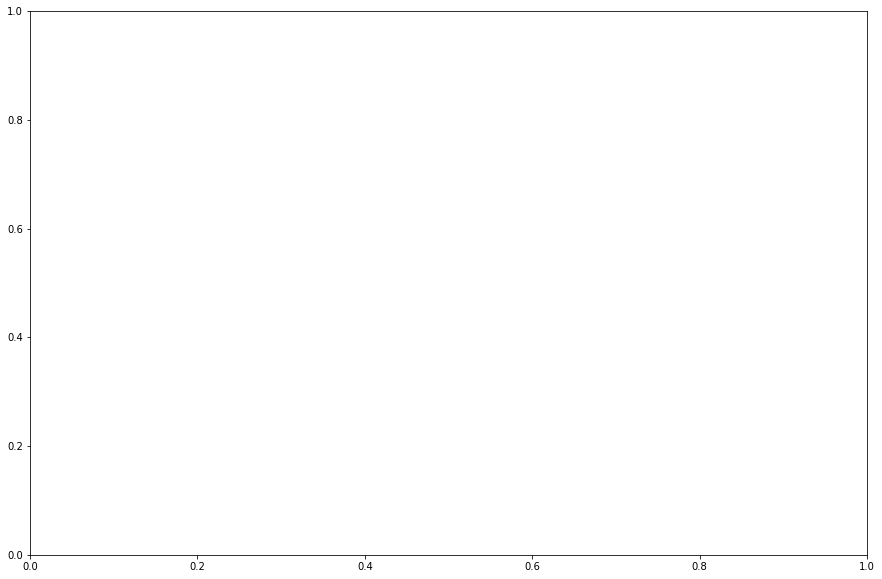

In [78]:
plt.figure(figsize = (15, 10))
plt.plot(reponse[0], reponse[1])
plt.grid()
plt.xlabel("Nombres de sujets")
plt.ylabel("Moyenne prédiction")
plt.savefig("Courbe precision.png", dpi = 300)